In [ ]:
import numpy as np
import torch
import flwr as fl
from flwr.common import Metrics
import utils
from torchvision.models import segmentation
from collections import OrderedDict
from Pyfhel import Pyfhel
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
import os
from strategy import FedAvgEncrypted
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    Metrics,
)
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Loading the data

In [2]:
DEVICE = torch.device("cuda")
NUM_CLIENTS = 10

# Split the data to train-, valloaders 
trainloaders, valloaders = utils.load_datasets_federated(batch_size=8, num_clients=NUM_CLIENTS, path='data')

Total samples in trainloaders: 810
Total samples in valloaders: 90


# Federated Learning

In [ ]:
if not os.path.exists("pyfhel"):
    os.makedirs("pyfhel")
    
SECURITY_LEVEL = 128  
SCALE = 2**26
QI_SIZES = [60,30,60]


HE = Pyfhel()
ckks_params = {'scheme': 'CKKS', 'n': 2**15, 'scale': SCALE,'qi_sizes': QI_SIZES, 'sec': SECURITY_LEVEL}
HE.contextGen(**ckks_params)  
HE.keyGen()
HE.save_context("pyfhel/context")
HE.save_public_key("pyfhel/pub.key")
HE.save_secret_key("pyfhel/sec.key")
    # HE.save_relin_key("pyfhel/relin.key")

In [4]:
class FlowerClient(fl.client.Client):
    def __init__(self, net, cid, trainloader, valloader, encrypt):
        self.net = net
        self.cid = cid
        self.trainloader = trainloader
        self.valloader = valloader
        self.encrypt = encrypt
        self.original_shapes = self.get_original_shapes()
        
        if self.encrypt:
            self.HE = Pyfhel()
            self.HE.load_context('pyfhel/context')
            self.HE.load_public_key("pyfhel/pub.key")
            self.HE.load_secret_key("pyfhel/sec.key")
            
    def get_original_shapes(self):
        ndarrays = utils.get_parameters(self.net)
        return [param.shape for param in ndarrays]
    
    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        ndarrays = utils.get_parameters(self.net)
        if self.encrypt:
            start_time = time.time()
            flat_parameters, self.original_shapes = utils.flatten_parameters(ndarrays)
            encrypted_batches = utils.encrypt(flat_parameters, self.HE)
            parameters = utils.serialize(encrypted_batches)
            end_time = time.time()
            total_time = end_time - start_time
            print(f'Encryption time: {total_time}')
        else:
            parameters = ndarrays_to_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")
        parameters_original = ins.parameters
        
        if self.encrypt:
            start_time = time.time()
            encrypted_batches = utils.deserialize(parameters_original, self.HE)
            parameters = utils.decrypt(encrypted_batches, self.HE, self.original_shapes)
            end_time = time.time()
            total_time = end_time - start_time
            print(f'Decryption time: {total_time}')
        else:
            parameters = parameters_to_ndarrays(parameters_original)
        utils.set_parameters(self.net, parameters)

        start_time = time.time()
        utils.train(self.net, self.trainloader, epochs=1, device=DEVICE, verbose=False)
        end_time = time.time()
        total_time = end_time - start_time
        print(f'Train time: {total_time}')
        # loss, iou_score, accuracy, f_score = utils.test(self.net, self.valloader, device=DEVICE)
        # print(f"Metrics after training: \nLoss: {loss}, IoU score: {iou_score}, \n Accuracy: {accuracy}")
        parameters = utils.get_parameters(self.net)
        if self.encrypt:
            start_time = time.time()
            flat_parameters, self.original_shapes = utils.flatten_parameters(parameters)
            encrypted_batches = utils.encrypt(flat_parameters, self.HE)
            parameters_updated = utils.serialize(encrypted_batches)
            end_time = time.time()
            total_time = end_time - start_time
            print(f'Encryption time: {total_time}')
        else:
            parameters_updated = ndarrays_to_parameters(parameters)
        
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")
        parameters_original = ins.parameters
        if self.encrypt:
            start_time = time.time()
            encrypted_batches = utils.deserialize(parameters_original, self.HE)
            parameters = utils.decrypt(encrypted_batches, self.HE, self.original_shapes)
            end_time = time.time()
            total_time = end_time - start_time
            print(f'Decryption time: {total_time}')
        else:
            parameters = parameters_to_ndarrays(parameters_original)

        utils.set_parameters(self.net, parameters)
        start_time = time.time()
        loss, iou_score, accuracy, f_score = utils.test(self.net, self.valloader, device=DEVICE)
        end_time = time.time()
        total_time = end_time - start_time
        print(f'Evaluate time: {total_time}')
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"iou": float(iou_score),
                    "accuracy": float(accuracy),
                    "f_score": float(f_score)},
        )

In [5]:
os.environ['PYTHONWARNINGS'] = "ignore"
importlib.reload(utils)


ENCRYPT = True # Change this to enable/disable encryption
FIT_FRAC = [0.5]
EVAL_FRAC = 0.5
NUM_ROUNDS = 30
results = []

def client_fn(cid: str, encrypt = ENCRYPT) -> FlowerClient:
    net = segmentation.lraspp_mobilenet_v3_large(num_classes=3).to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(net, cid, trainloader, valloader, encrypt)


for fraction_fit in FIT_FRAC:
    if ENCRYPT:
        strategy = FedAvgEncrypted(
            fraction_fit=fraction_fit,
            fraction_evaluate=EVAL_FRAC, 
            evaluate_metrics_aggregation_fn=utils.weighted_average
        )
    else:
        strategy = fl.server.strategy.FedAvg(
            fraction_fit=fraction_fit, 
            fraction_evaluate=EVAL_FRAC, 
            evaluate_metrics_aggregation_fn=utils.weighted_average,
        )

    client_resources = None
    if DEVICE.type == "cuda":
        client_resources = {"num_gpus": 1}

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
        client_resources=client_resources,
    )
    
    # Save the results in a file
    if not os.path.exists('results'):
        os.makedirs('results')

    encryption = "_HE" if ENCRYPT else ""
    
    if SECURITY_LEVEL == 256:
        security = "_256sec"
    elif SECURITY_LEVEL == 192:
        security = "_192sec"
    else: 
        security = "_sec128"

    with open(f'results/{str(SCALE)}{security}_{NUM_ROUNDS}rounds_{round(fraction_fit*NUM_CLIENTS)}clients{encryption}.txt', 'w') as f:
        f.write(str(history))
        
    results.append(str(history))

INFO flwr 2023-07-14 09:35:08,609 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
INFO flwr 2023-07-14 09:35:13,513 | app.py:180 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:127.0.0.1': 1.0, 'memory': 12643356672.0, 'object_store_memory': 6321678336.0, 'CPU': 12.0}
INFO flwr 2023-07-14 09:35:13,514 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-14 09:35:13,515 | server.py:273 | Requesting initial parameters from one random client


 pid=11524) Encryption time: 3.1600515842437744


INFO flwr 2023-07-14 09:35:25,138 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-07-14 09:35:25,139 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-07-14 09:35:25,139 | server.py:101 | FL starting
DEBUG flwr 2023-07-14 09:35:25,140 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 10)


 pid=11524) [Client 5] fit, config: {}
 pid=11524) Decryption time: 1.6181037425994873
 pid=11524) Train time: 4.099517107009888
 pid=11524) Encryption time: 3.1872646808624268
 pid=11524) [Client 1] fit, config: {}
 pid=11524) Decryption time: 1.5083212852478027
 pid=11524) Train time: 0.9609053134918213
 pid=11524) Encryption time: 3.182577133178711
 pid=11524) [Client 7] fit, config: {}
 pid=11524) Decryption time: 1.416553258895874
 pid=11524) Train time: 0.8420016765594482
 pid=11524) Encryption time: 3.1613974571228027
 pid=11524) [Client 4] fit, config: {}
 pid=11524) Decryption time: 1.3754312992095947
 pid=11524) Train time: 0.8466417789459229
 pid=11524) Encryption time: 3.1721808910369873
 pid=11524) [Client 3] fit, config: {}
 pid=11524) Decryption time: 1.3805155754089355
 pid=11524) Train time: 0.8185570240020752
 pid=11524) Encryption time: 3.244335412979126


DEBUG flwr 2023-07-14 09:36:08,939 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-07-14 09:36:10,352 | strategy.py:119 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-07-14 09:36:10,372 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 10)


Aggregation time: 1.4125688076019287
 pid=11524) [Client 0] evaluate, config: {}
 pid=11524) Decryption time: 2.4935803413391113
 pid=11524) Evaluate time: 0.574476957321167
 pid=11524) [Client 9] evaluate, config: {}
 pid=11524) Decryption time: 1.4070947170257568
 pid=11524) Evaluate time: 0.45513415336608887
 pid=11524) [Client 3] evaluate, config: {}
 pid=11524) Decryption time: 1.3665485382080078
 pid=11524) Evaluate time: 0.4898722171783447
 pid=11524) [Client 2] evaluate, config: {}
 pid=11524) Decryption time: 1.3919000625610352
 pid=11524) Evaluate time: 0.5848710536956787
 pid=11524) [Client 5] evaluate, config: {}
 pid=11524) Decryption time: 1.363830804824829


DEBUG flwr 2023-07-14 09:36:28,500 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-07-14 09:36:28,500 | server.py:218 | fit_round 2: strategy sampled 5 clients (out of 10)


 pid=11524) Evaluate time: 0.4776160717010498
 pid=11524) [Client 8] fit, config: {}
 pid=11524) Decryption time: 1.598243236541748
 pid=11524) Train time: 0.8702132701873779
 pid=11524) Encryption time: 3.3199493885040283
 pid=11524) [Client 1] fit, config: {}
 pid=11524) Decryption time: 1.4749860763549805
 pid=11524) Train time: 0.776400089263916
 pid=11524) Encryption time: 3.5806713104248047
 pid=11524) [Client 7] fit, config: {}
 pid=11524) Decryption time: 1.3620076179504395
 pid=11524) Train time: 0.861086368560791
 pid=11524) Encryption time: 3.136719226837158
 pid=11524) [Client 5] fit, config: {}
 pid=11524) Decryption time: 1.4191157817840576
 pid=11524) Train time: 0.9260845184326172
 pid=11524) Encryption time: 3.227283477783203
 pid=11524) [Client 9] fit, config: {}
 pid=11524) Decryption time: 1.3701212406158447
 pid=11524) Train time: 0.7553672790527344


 pid=11524) Encryption time: 3.2550134658813477


DEBUG flwr 2023-07-14 09:37:07,597 | server.py:232 | fit_round 2 received 5 results and 0 failures


# Plot Performance

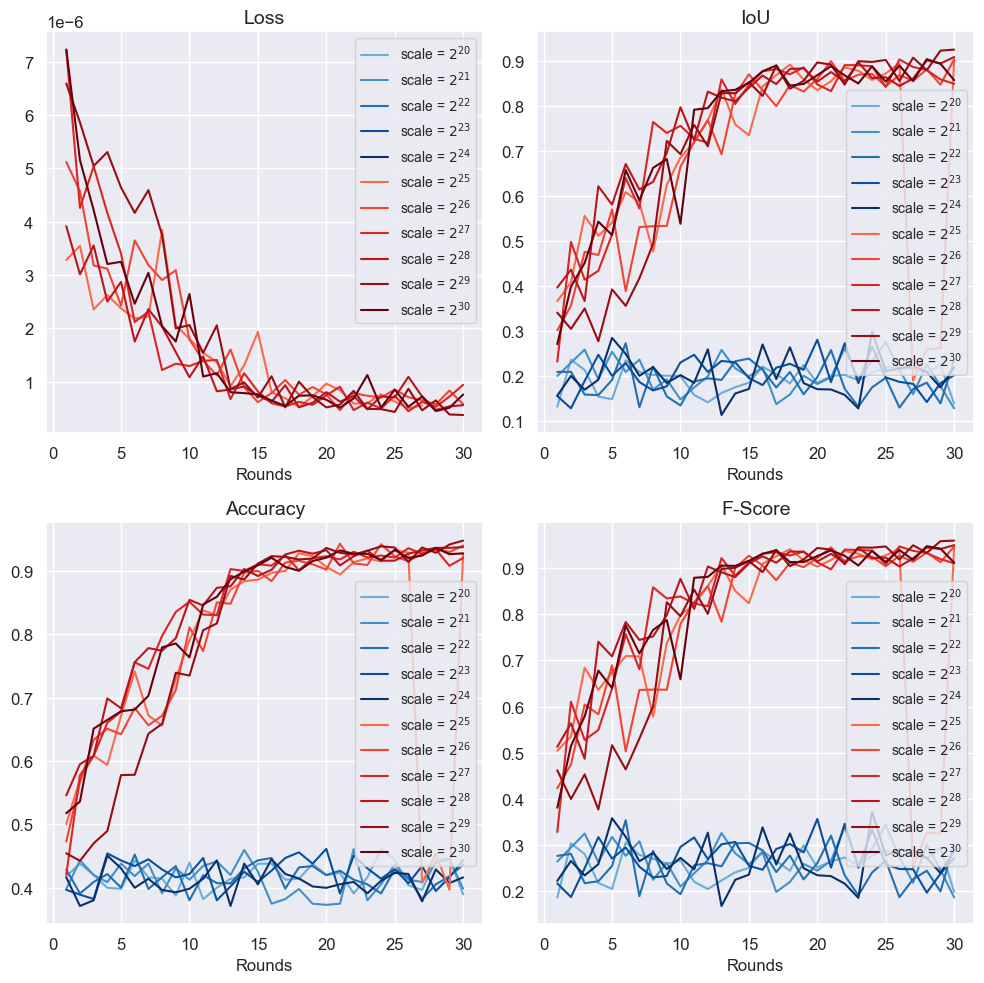

In [ ]:


file_names = [
"results/new/1048576_sec128_30rounds_5clients_HE.txt",
"results/new/2097152_sec128_30rounds_5clients_HE.txt",
"results/new/4194304_sec128_30rounds_5clients_HE.txt",
"results/new/8388608_sec128_30rounds_5clients_HE.txt",
"results/new/16777216_sec128_30rounds_5clients_HE.txt",
"results/new/33554432_sec128_30rounds_5clients_HE.txt",
"results/new/67108864_sec128_30rounds_5clients_HE.txt",
"results/new/134217728_sec128_30rounds_5clients_HE.txt",
"results/new/268435456_sec128_30rounds_5clients_HE.txt",
"results/new/536870912_sec128_30rounds_5clients_HE.txt",
"results/new/1073741824_sec128_30rounds_5clients_HE.txt"]
file_results = []
labels = [f'scale = $2^{{20}}$',f'scale = $2^{{21}}$',f'scale = $2^{{22}}$',f'scale = $2^{{23}}$',f'scale = $2^{{24}}$',f'scale = $2^{{25}}$',f'scale = $2^{{26}}$',f'scale = $2^{{27}}$',f'scale = $2^{{28}}$',f'scale = $2^{{29}}$',f'scale = $2^{{30}}$']

for file_name in file_names:
    with open(file_name, 'r') as file:
        file_results.append(file.read())
file_results = utils.parse_results(file_results)



sns.set_theme()
plt.rc('axes', labelsize=14) 
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12) 

colors1 = cm.Blues(np.linspace(0.5, 1, 5))
colors2 = cm.Reds(np.linspace(0.5, 1, len(file_results) - 5)) 
colors = np.vstack((colors1, colors2))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, metric in enumerate(file_results[0].keys()):
    row = i // 2
    col = i % 2
    for j in range(len(file_results)):
        x_values = list(range(1, len(file_results[j][metric]) + 1))
        y_values = file_results[j][metric]
        color = colors[j] 
        axs[row, col].plot(x_values, y_values, color=color, label=labels[j])
        axs[row, col].set_title(metric, fontsize=14)
        axs[row, col].set_xlabel('Rounds', fontsize=12)
        axs[row, col].legend(fontsize='small')

plt.tight_layout()
plt.show()


# Plot plain vs encrypted

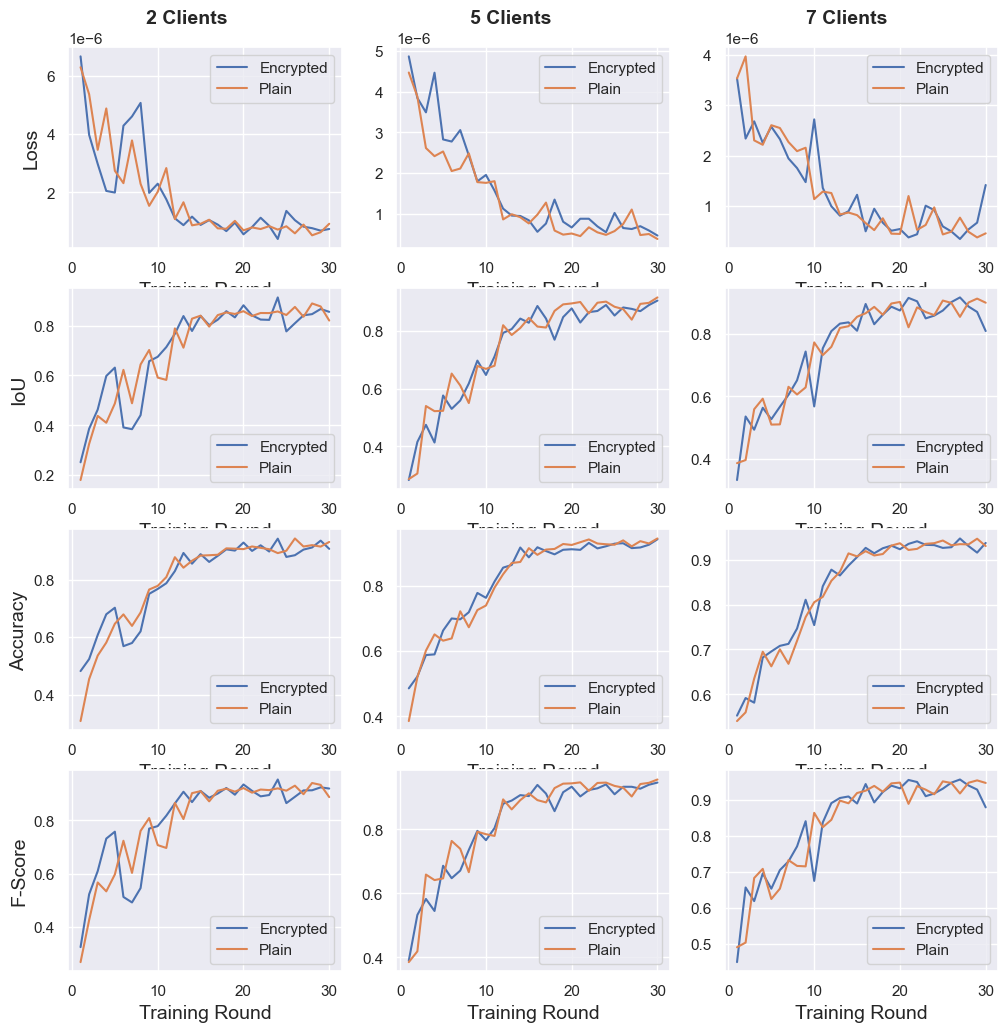

In [ ]:
results_HE = []
results_plain = []


for file_name in ["results_new_30rounds_2clients_HE.txt", "results_new_30rounds_5clients_HE.txt", "results_new_30rounds_7clients_HE.txt"]:
    with open("results/" + file_name, 'r') as file:
        results_HE.append(file.read())
results_HE = utils.parse_results(results_HE)

for file_name in ["results_new_30rounds_2clients.txt", "results_new_30rounds_5clients.txt", "results_new_30rounds_7clients.txt"]:
    with open("results/" + file_name, 'r') as file:
        results_plain.append(file.read())
results_plain = utils.parse_results(results_plain)


sns.set_theme()
gs = gridspec.GridSpec(4, 3)
fig = plt.figure(figsize=(12, 12))
clients = [2, 5, 7]
keys = list(results_HE[0].keys())

for i in range(4):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        metric = keys[i]
        client = clients[j]
    
        y1 = results_HE[j][metric]
        y2 = results_plain[j][metric]
        x1 = list(range(1, len(y1) + 1))
        x2 = list(range(1, len(y2) +1))
        ax.plot(x1, y1, label='Encrypted')
        ax.plot(x2, y2, label='Plain')
        ax.set_xlabel('Training Round', fontsize=14)
        if j == 0:
            ax.set_ylabel(metric, fontsize=14)
        else:
            ax.set_ylabel('')
        ax.legend()

fig.text(0.19, 0.9, f'{clients[0]} Clients', fontweight='bold', fontsize=14)
fig.text(0.46, 0.9, f'{clients[1]} Clients', fontweight='bold', fontsize=14)
fig.text(0.74, 0.9, f'{clients[2]} Clients', fontweight='bold', fontsize=14)

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.show()

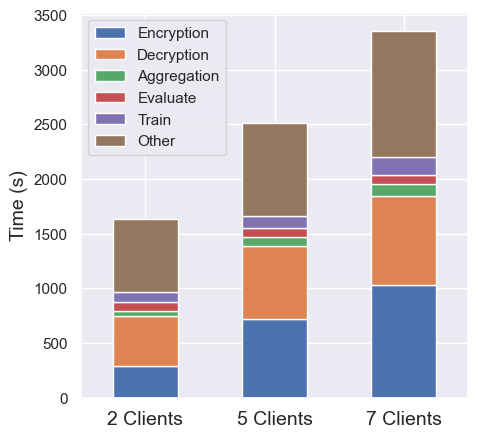

In [ ]:



def process_file(file_path):
    data = {
        'Encryption': [],
        'Decryption': [],
        'Aggregation': [],
        'Evaluate': [],
        'Train': [],
        'Other': []
    }

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            category, time = line.split(":")
            category = category.replace(' time', '')  
            time = float(time.strip())
            if category in data:
                data[category].append(time)
        max_length = max(len(times) for times in data.values())
        for category, times in data.items():
            if len(times) < max_length:
                data[category].extend([0] *(max_length-len(times)))

    df = pd.DataFrame(data)
    df = df.sum().to_frame().transpose()
    return df
df1 = process_file('results/time_measurements/times_128sec_30rounds_2clients_HE_large_qi_size.txt')
df2 = process_file('results/time_measurements/times_128sec_30rounds_5clients_HE_large_qi_size.txt')
df3 = process_file('results/time_measurements/times_128sec_30rounds_7clients_HE_large_qi_size.txt')
df1['Total'] = 1636.3764594999998
df2['Total'] = 2514.1626132
df3['Total'] = 3352.8459985000004

df = pd.concat([df1, df2, df3])

df['Other'] = df['Total'] - df.drop(columns='Total').sum(axis=1)
df = df.drop(columns='Total')

df.plot(kind='bar', stacked=True, figsize=(5, 5))
plt.ylabel('Time (s)', fontsize=14)
plt.xticks([0, 1, 2], ['2 Clients', '5 Clients', '7 Clients'], rotation=0, fontsize=14)
plt.xlabel('')
plt.show()